# Fusing Batch Norm Layers
In this notebook the weights of the batch normalization layers in the **TinyYolo** Network will be fused with their corresponding weights of the convulational layer, in order to speed up inference.

## Prepare Workspace

### Define GOOGLE COLAB Flag

In [ ]:
GOOGLE_COLAB = True

### Mount Google Drive

In [ ]:
if GOOGLE_COLAB:
    import os
    from google.colab import drive

    # Check if Google Drive is already mounted
    if not os.path.exists('/content/drive/My Drive'):
        print("Mounting Google Drive...")
        drive.mount('/content/drive')
    else:
        print("Google Drive is already mounted.")

### Set-up Directories & Install Libraires
Create the directories needed and copy uploaded files into them.

In [ ]:
if GOOGLE_COLAB:
    !pip install torchinfo
    !pip install torchvision pillow

    !mkdir /content/data

    !cp /content/drive/MyDrive/eml_challenge/data/person_indices.json /content/data
    !cp -r /content/drive/MyDrive/eml_challenge/utils /content
    !cp /content/drive/MyDrive/eml_challenge/tinyyolov2.py /content
    !cp /content/drive/MyDrive/eml_challenge/tinyyolov2_fused.py /content

### Define Path to Weights

In [ ]:
if GOOGLE_COLAB:
    WEIGHTS_PATH = "/content/drive/MyDrive/eml_challenge/weights/"
else:
    WEIGHTS_PATH = "./"

### Append Directory Paths to System Path

In [ ]:
import sys
if GOOGLE_COLAB:
    sys.path.append('/content')
    sys.path.append('/content/data')
    sys.path.append('/content/utils')
    sys.path.append(WEIGHTS_PATH)

### Import Libraires

In [ ]:
# Pytorch libraries
import torch
import torchinfo
import torch.nn as nn
from torch.utils.data import Subset

# Other libraires
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import time

# EML libraires
from tinyyolov2 import TinyYoloV2
from tinyyolov2_fused import FusedTinyYoloV2
from utils.dataloader_v2 import VOCDataset
from utils.ap import precision_recall_levels, ap, display_roc
from utils.yolo import nms, filter_boxes

## Define Functions

### Define fuse_conv_bn_weights Function
This fucntion calculates fuses one convolutional layer with its corresponding batch normalization layer and calculates the new weights.

In [ ]:
def fuse_conv_bn_weights(conv_w, bn_rm, bn_rv, bn_w, bn_b):
    """
    Input:
        conv_w: shape=(output_channels, in_channels, kernel_size, kernel_size)
        conv_b: shape=(output_channels)
        bn_rm:  shape=(output_channels)
        bn_rv:  shape=(output_channels)
        bn_w:   shape=(output_channels)
        bn_b:   shape=(output_channels)

    Output:
        fused_conv_w = shape=conv_w
        fused_conv_b = shape=conv_b
    """
    bn_eps = 1e-05

    fused_conv = torch.zeros(conv_w.shape)
    fused_bias = torch.zeros(conv_w.shape[0])

    conv_b = torch.zeros(conv_w.shape[0])

    for output_channel in range(conv_w.shape[0]):
        fused_conv[output_channel] = conv_w[output_channel] * bn_w[output_channel] / ((bn_rv[output_channel] + bn_eps)** (1/2))
        fused_bias[output_channel] = bn_b[output_channel] + ((bn_w[output_channel] * (conv_b[output_channel] - bn_rm[output_channel])) / ((bn_rv[output_channel] + bn_eps)** (1/2)))

    return fused_conv, fused_bias

### Define fuse_conv_bn_net Function
This function accepts the state dictionary as well as the number of convolutional layers to be fused with their corresponding batch normalization layers.

In [ ]:
def fuse_conv_bn_net(state_dict, num_conv_layers):
    fused_dict = {}

    for i in range(1, num_conv_layers+1):
        fused_dict["conv" + str(i) + ".weight"], fused_dict["conv" + str(i) + ".bias"] = fuse_conv_bn_weights(
                                                                state_dict["conv" + str(i) + ".weight"],
                                                                state_dict["bn" + str(i) + ".running_mean"],
                                                                state_dict["bn" + str(i) + ".running_var"],
                                                                state_dict["bn" + str(i) + ".weight"],
                                                                state_dict["bn" + str(i) + ".bias"])
    fused_dict["conv9.weight"] = state_dict["conv9.weight"]
    fused_dict["conv9.bias"]   = state_dict["conv9.bias"]
    fused_dict["anchors"]      = state_dict["anchors"]
    return fused_dict

### Define net_time Function

In [ ]:
def net_time(net, test_loader):
    net.eval()

    t_start = time.time()

    for _, (inputs, _) in tqdm.tqdm(enumerate(test_loader), total=len(test_loader)):
        net.forward(inputs)

    t_end = time.time()
    t = t_end - t_start

    return t

### Define test Function

In [ ]:
def test(net: nn.Module, data_loader: torch.utils.data.DataLoader, device):
    """
    Description:
    This function tests the network.

    Args:
    net: the network to test
    data_loader: the data loader for the test set
    device: the device to use for training
    num_validation_samples: the number of passed images to the validate function
    """

    test_precision = []
    test_recall = []

    net.to(device)
    net.eval()

    with torch.no_grad():
        for idx, (input, target) in tqdm.tqdm(enumerate(data_loader), total=len(data_loader)):
            input  = input.to(device)
            target = target.to(device)
            output = net(input, yolo=True)
            #The right threshold values can be adjusted for the target application
            output = filter_boxes(output, CONFIDENCE_THRESHOLD)
            output = nms(output, NMS_THRESHOLD)
            # Calculate precision and recall for each sample
            for i in range(len(target)):
                precision, recall = precision_recall_levels(target[i], output[i])
                test_precision.append(precision)
                test_recall.append(recall)

    # Calculate average precision with collected samples
    average_precision = ap(test_precision, test_recall)
    # Plot ROC
    display_roc(test_precision, test_recall)

    return average_precision

## Execute Workspace

### Hyperparameters

In [ ]:
# Thresholds
CONFIDENCE_THRESHOLD     = 0.0
NMS_THRESHOLD            = 0.5
# Batch Size
TEST_BATCH_SIZE         = 128

### Define Variables

In [ ]:
if torch.cuda.is_available():
      torch_device = torch.device("cuda")
      print("Using GPU")
else:
    torch_device = torch.device("cpu")
    print("Using CPU")

net       = TinyYoloV2(num_classes=1)
fused_net = FusedTinyYoloV2(num_classes=1)

test_dataset  = VOCDataset(root="/content/data", year="2012", image_set='val', only_person=True)   # Contains 2232 pictures
test_loader   = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)

Using CPU
Dataset not found at /content/data/VOCdevkit/VOC2012. Downloading...


100%|██████████| 2.00G/2.00G [06:33<00:00, 5.09MB/s]


Extracting /content/data/VOCtrainval_11-May-2012.tar to /content/data


### Fuse Batch and Conv Layers
Fuse batch normalization layers to their corresponding convolutional layers and load them to the chosen device

In [ ]:
# Since the last convolutional layer doesn't have a batch normalization layer
# after it, NUM_CONV_LAYERS was set to 8
NUM_CONV_LAYERS = 8

sd = torch.load(WEIGHTS_PATH + "voc_fine_tuned.pt", weights_only=True, map_location=torch_device)
net.load_state_dict(sd, strict=False)

sd_fused = fuse_conv_bn_net(state_dict=sd, num_conv_layers=NUM_CONV_LAYERS)
fused_net.load_state_dict(sd_fused, strict=False)

<All keys matched successfully>

### Timing Benchmark for Inference before Fusion

In [ ]:
print(f"\nInference Time before Fusion: {net_time(net, test_loader):.3}")

100%|██████████| 18/18 [01:08<00:00,  3.78s/it]


Inference Time before Fusion: 68.1


### Timing Benchmark for Inference after Fusion

In [ ]:
print(f"\nInference Time after Fusion: {net_time(fused_net, test_loader):.3}")

100%|██████████| 18/18 [01:01<00:00,  3.44s/it]


Inference Time after Fusion: 62.0


### Average Precision Benchmark for TinyYolov2

100%|██████████| 18/18 [03:44<00:00, 12.50s/it]


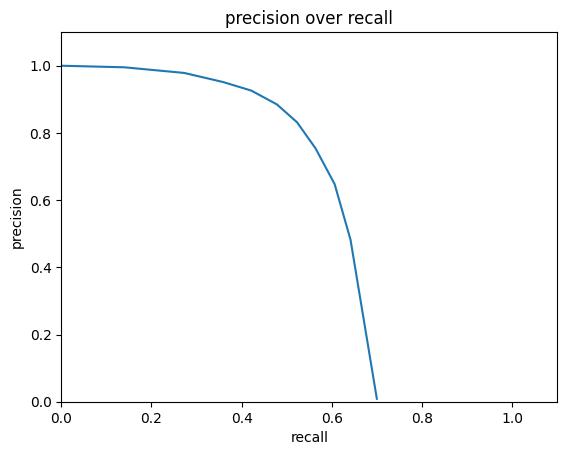

Average Precision before Fusion: 57.551%


In [ ]:
average_precision_before_fusion = test(net, test_loader, torch_device)
print(f"Average Precision before Fusion: {average_precision_before_fusion:.3%}")

### Average Precision Benchmark for FusedTinyYolov2

100%|██████████| 18/18 [03:37<00:00, 12.08s/it]


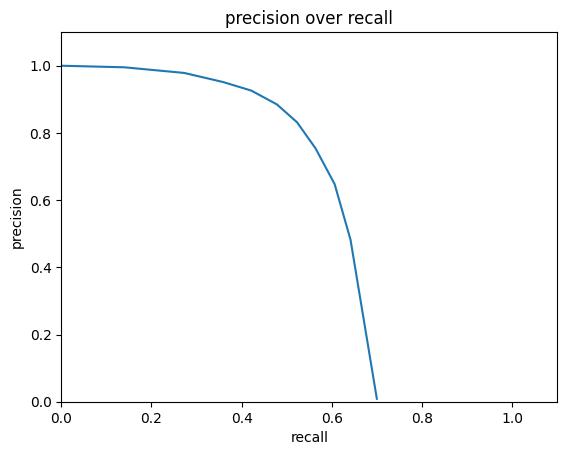

Average Precision after Fusion: 57.551%


In [ ]:
average_precision_after_fusion = test(fused_net, test_loader, torch_device)
print(f"Average Precision after Fusion: {average_precision_after_fusion:.3%}")

### Save fused Weights

In [ ]:
torch.save(fused_net.state_dict(), WEIGHTS_PATH + "fused_voc_fine_tuned.pt")